In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-02 14:34:41


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [4]:
import invisible_cities.icaro.mpl_functions as mpl

In [5]:
import invisible_cities.evm.event_model as evm

In [6]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [7]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [8]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [9]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [10]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [11]:
RWF_file = os.path.join(os.environ['IC_DATA'], 'MC_PreProd_July_2017',
                        'electrons.2615keV_RWF.z250mm.10evts.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/electrons.2615keV_RWF.z250mm.10evts.h5


In [12]:
h5rwf = tb.open_file(RWF_file,'r')

In [13]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [15]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 6, max = 30),  #150 ns -- 500 ns
                           rebin_stride  = 1)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 120, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

thresholds = ThresholdParams(thr_s1=3.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=15*units.pes)



In [16]:
event = 0

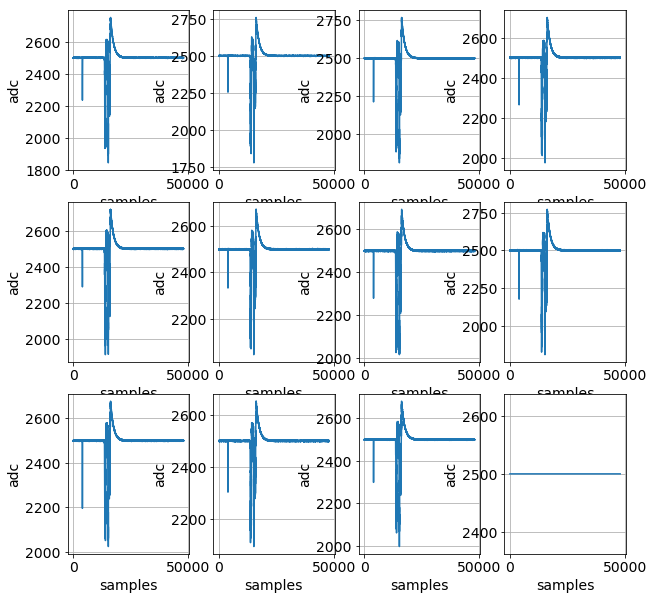

In [17]:
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [18]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

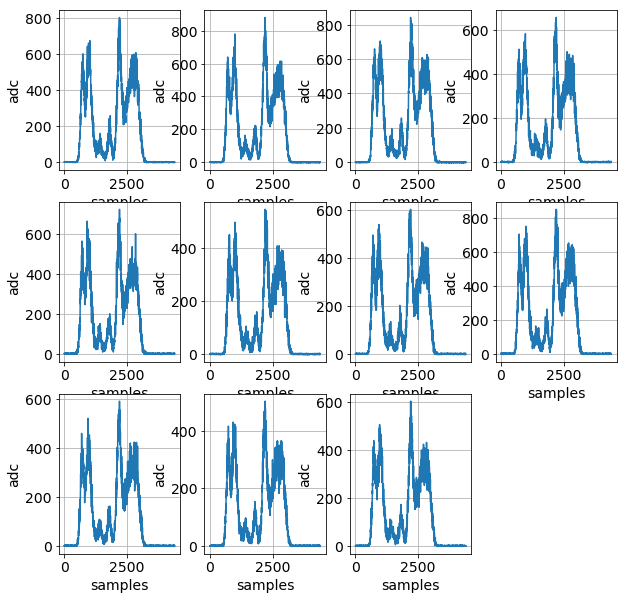

In [20]:
mpl.plot_pmt_waveforms(CWF, zoom=True, window_size=2200, figsize=(10,10))

#### csum

In [21]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

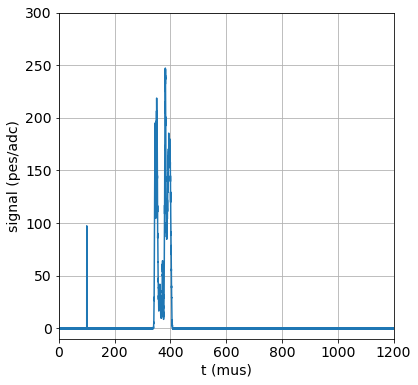

In [23]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1200,
                        signal_min =    -10,
                        signal_max =  300,
                        figsize=(6,6))

#### S1 and S2

In [24]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [25]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [26]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =      0.5 mus , energy =    736.2 pes
        height =     97.4 pes tmin-tmax = minmax(min=100.05, max=100.525) mus  

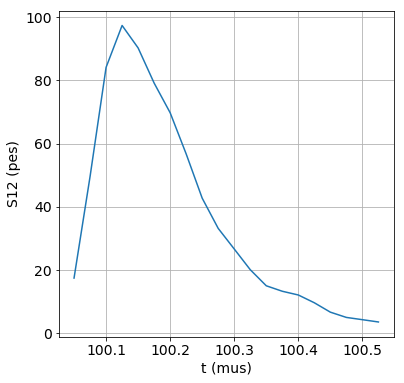

In [27]:
plot_s12(s1)

In [28]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 69 width =     67.6 mus , energy = 251261.5 pes
        height =   9471.0 pes tmin-tmax = minmax(min=339.6, max=407.21250000000003) mus  

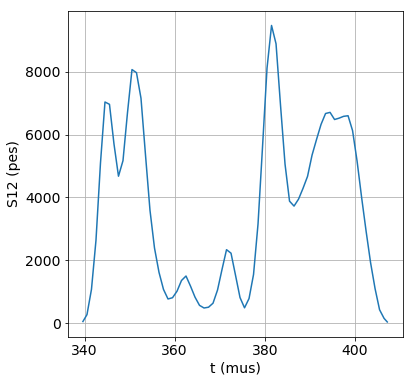

In [29]:
plot_s12(s2)

#### S2Si

In [30]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [31]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [32]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 69 width =     67.6 mus , energy = 251261.5 pes
        height =   9471.0 pes tmin-tmax = minmax(min=339.6, max=407.21250000000003) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (696, 766, 767, 1016, 1024, 1032, 1087, 1092, 1093, 1094, 1095, 1100, 1101, 1102, 1103, 1107, 1108, 1109, 1110, 1111, 1115, 1116, 1117, 1118, 1123, 1124, 1125, 1126, 1131, 1132, 1133, 1134, 1139, 1140, 1141, 1142, 1143, 1148, 1149, 1150, 1151, 1321, 1322, 1329, 1330, 1346, 1347, 1348, 1349, 1353, 1354, 1355, 1356, 1357, 1360, 1361, 1362, 1363, 1364, 1365, 1368, 1369, 1370, 1371, 1372, 1373, 1376, 1377, 1378, 1379, 1380, 1384, 1385, 1408, 1409, 1410, 1411, 1416, 1417, 1418, 1419, 1424, 1425, 1426, 1427, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1450, 1451, 1452, 1453, 1454, 1455, 1459, 1460, 1461)
------------

In [32]:
s2si.number_of_peaks

1

In [33]:
s2si.sipms_in_peak(0)

(1517, 1518, 1525, 1526, 1527, 1533, 1534)

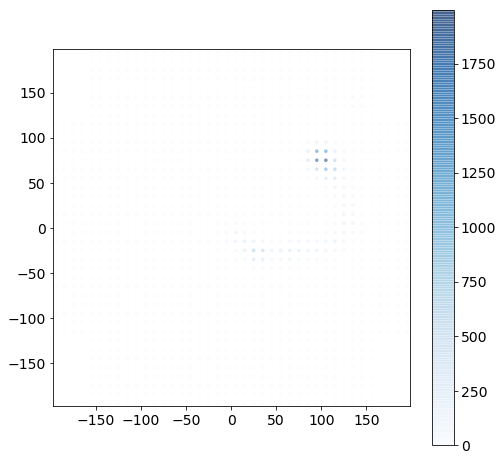

In [33]:
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =     15.3 pes
        height =      2.9 pes tmin-tmax = minmax(min=100.05, max=100.22500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.7 mus , energy =   3693.3 pes
        height =    741.0 pes tmin-tmax = minmax(min=515.675, max=525.35) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.7 mus , energy =   3693.3 pes
        height =    741.0 pes tmin-tmax = minmax(min=515.675, max=525.35) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (688, 696, 697, 1024, 1025, 1026)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 688
    sipm waveform (zs) = Peak(samples = 6 width =      5.0 mus , energy =     17.3 pes
        height =      4.0 pes tmin-tma

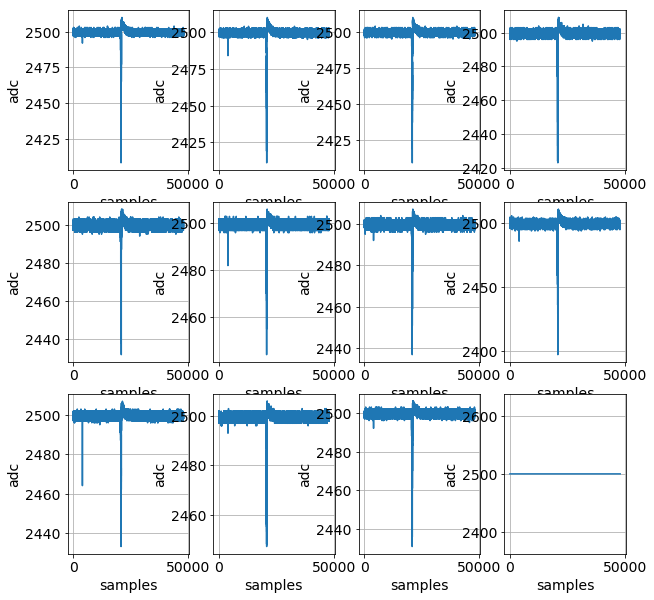

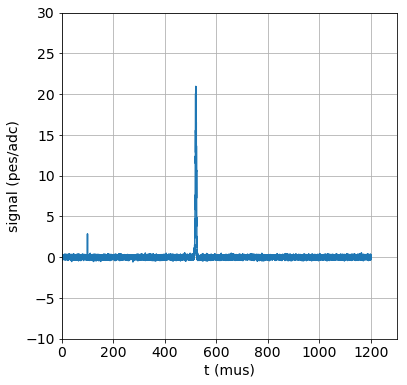

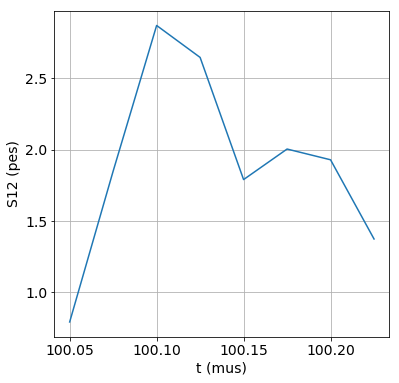

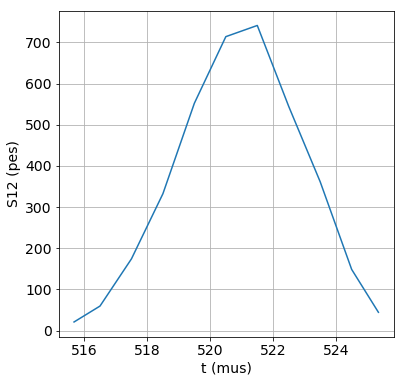

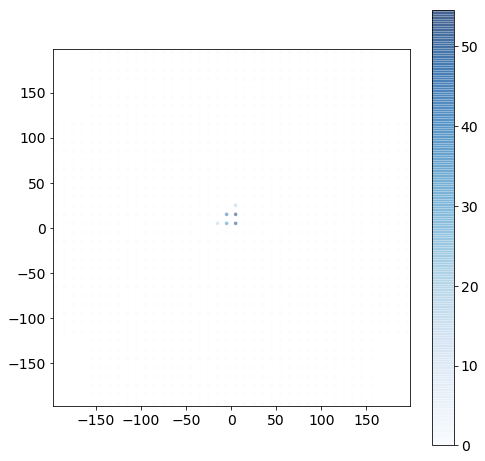

In [37]:
event = 1
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =      8.1 pes
        height =      1.8 pes tmin-tmax = minmax(min=100.075, max=100.2) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =   3441.2 pes
        height =    809.2 pes tmin-tmax = minmax(min=383.77500000000003, max=392.45) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =   3441.2 pes
        height =    809.2 pes tmin-tmax = minmax(min=383.77500000000003, max=392.45) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (776, 777, 784, 785, 792, 855)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 776
    sipm waveform (zs) = Peak(samples = 7 width =      6.0 mus , energy =     54.9 pes
        height =     24.0 pes t

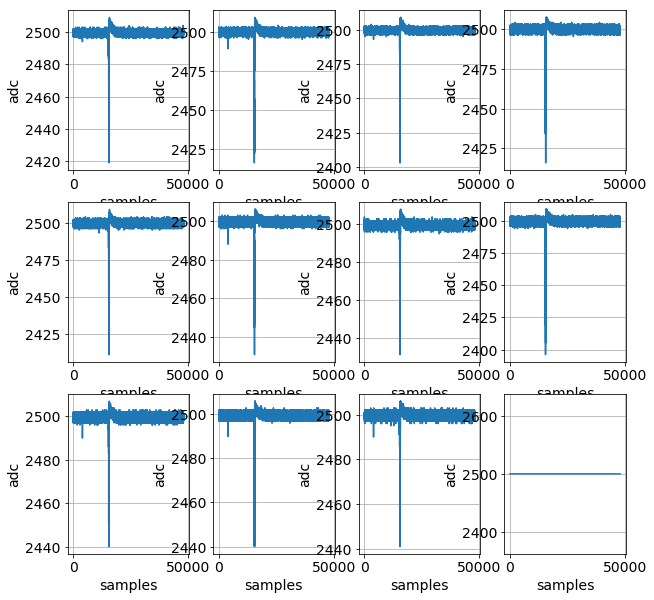

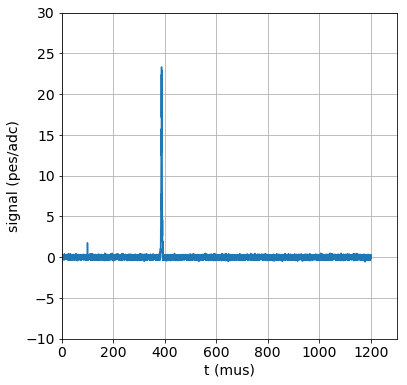

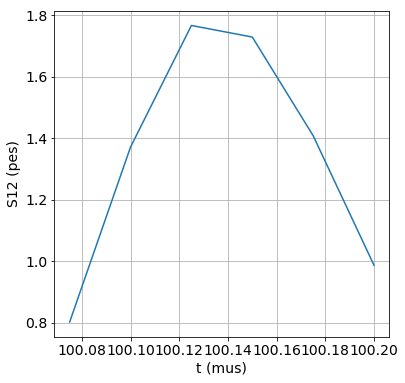

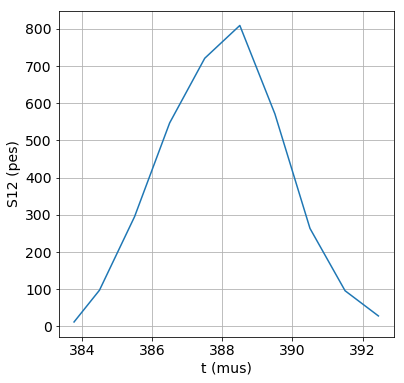

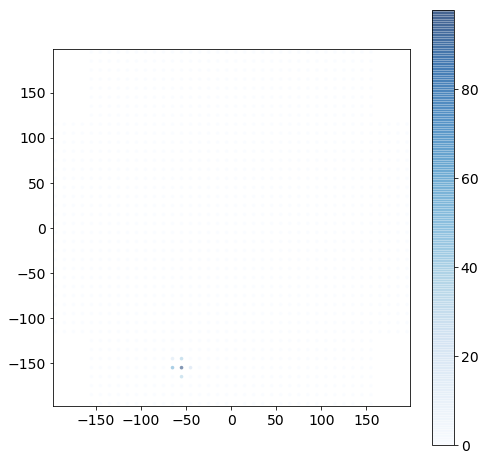

In [38]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 0)

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.2 mus , energy =   4327.0 pes
        height =   1251.7 pes tmin-tmax = minmax(min=232.9625, max=239.1875) mus  



ZeroDivisionError: float modulo

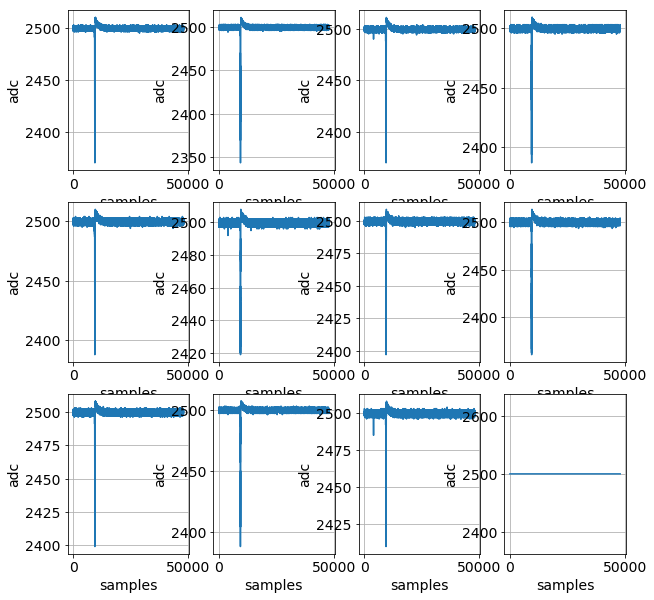

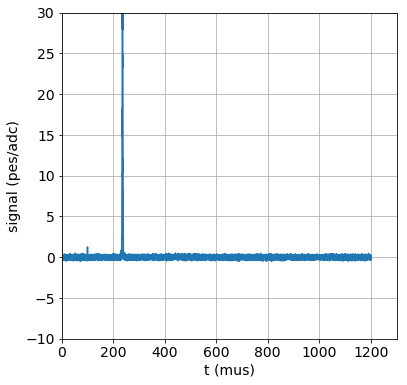

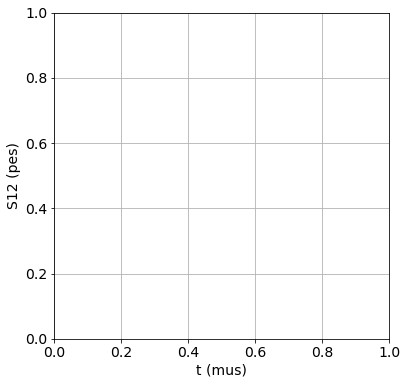

In [39]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =      7.6 pes
        height =      1.2 pes tmin-tmax = minmax(min=100.10000000000001, max=100.275) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1436, 1437, 1438, 1444, 1445)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1436
    sipm waveform (zs) = Peak(samples = 6 width =      4.8 mus , energy =     84.4 pes
        height =     29.9 pes tmin-tmax

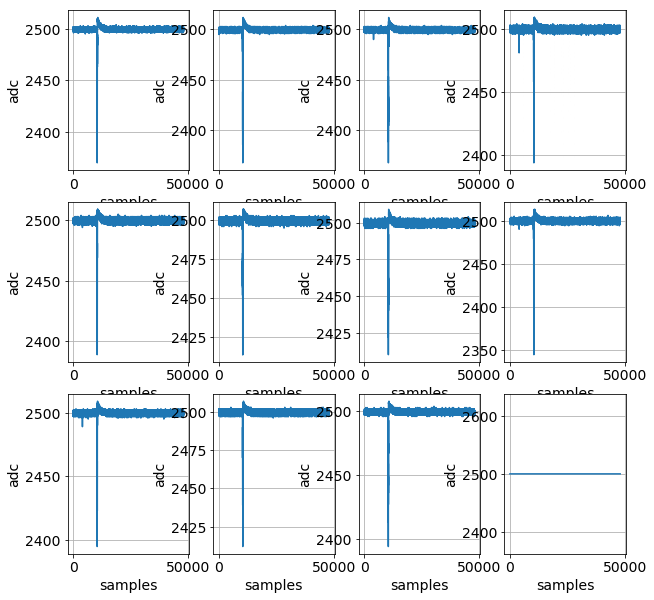

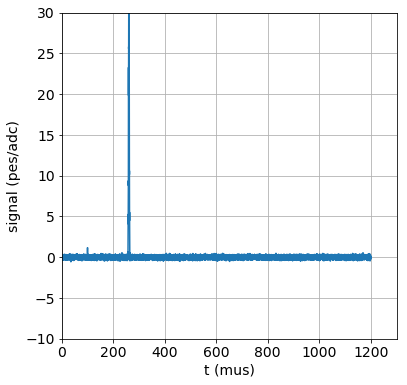

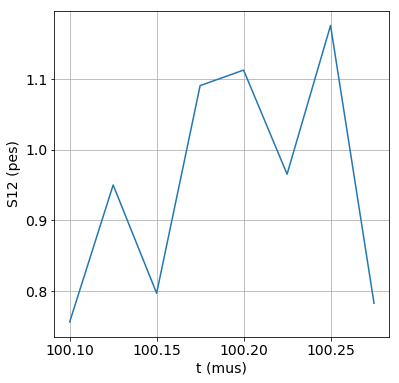

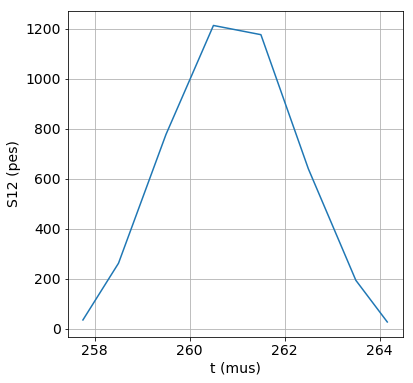

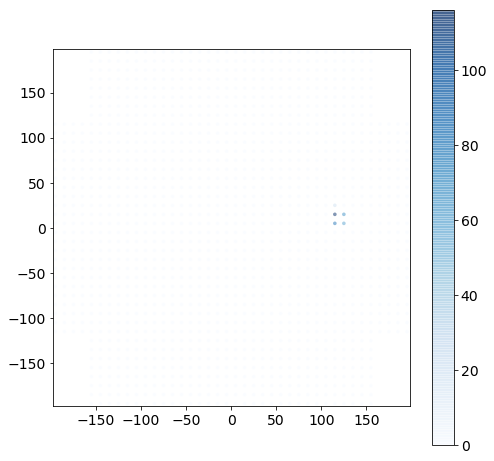

In [40]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     14.9 pes
        height =      2.8 pes tmin-tmax = minmax(min=100.075, max=100.22500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1493, 1494, 1501, 1502, 1503, 1509, 1510, 1511)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1493
    sipm waveform (zs) = Peak(samples = 5 width =      5.0 mus , energy =     16.6 p

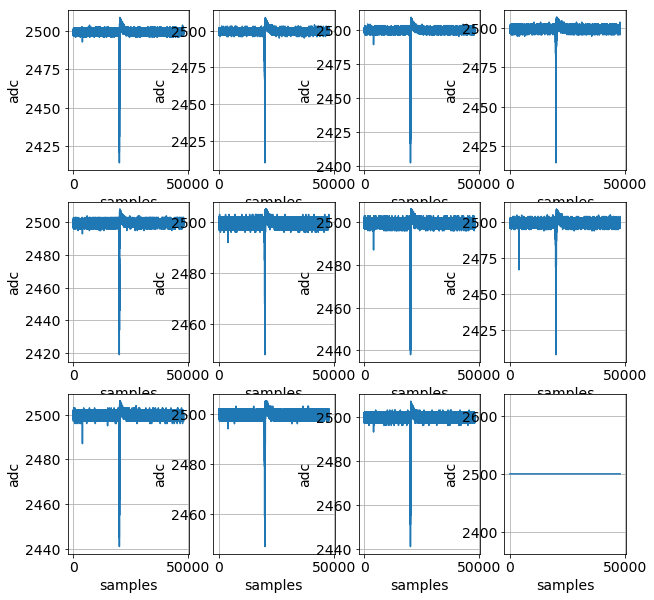

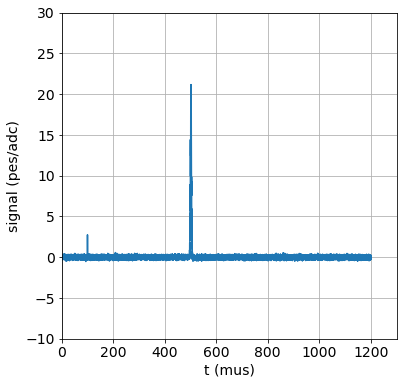

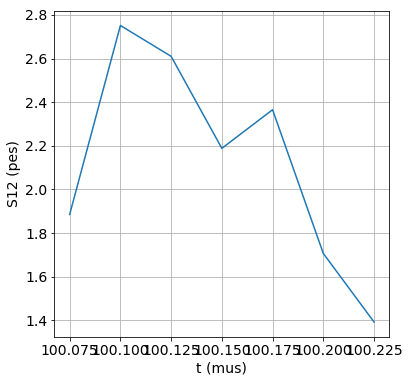

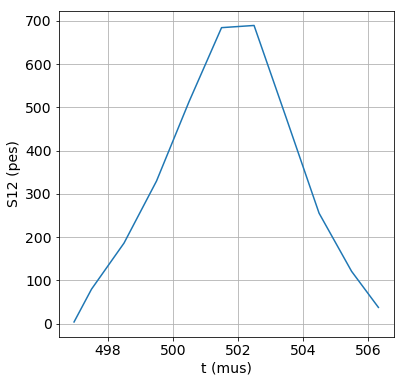

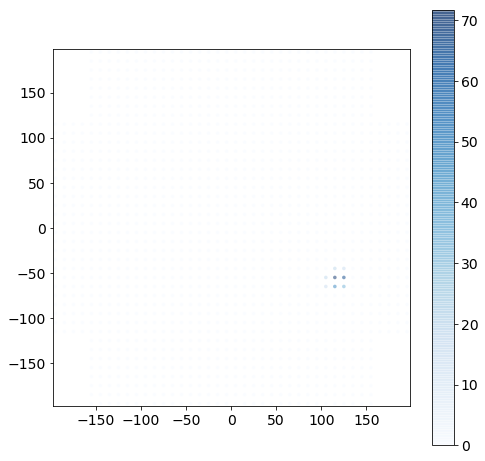

In [41]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)